In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Problem description

This notebook has been created as a first iteration of modelling for the Kaggle competition Home Credit - Credit Risk Model Stability (https://www.kaggle.com/competitions/home-credit-credit-risk-model-stability/overview).

Goal of this competition is to predict which client are likely to default on their loans, with an emphasis on model stability.

Main challenge of this classification problem are :
- Very large amount and diversity of data available (20G+)
- Limited amount of computing resources available for this modelling exercise
- Very imbalanced dataset classes
  

### Load data

In [2]:
base_df = pd.read_parquet('data/train/train_base.parquet')
base_df.head()

,case_id,date_decision,MONTH,WEEK_NUM,target
0,0,2019-01-03,201901,0,0
1,1,2019-01-03,201901,0,0
2,2,2019-01-04,201901,0,0
3,3,2019-01-03,201901,0,0
4,4,2019-01-04,201901,0,1


In [3]:
df_static_0_0 = pd.read_parquet('data/train/train_static_0_0.parquet')
df_static_0_1 = pd.read_parquet('data/train/train_static_0_1.parquet')
df_static_0 = pd.concat([df_static_0_0, df_static_0_1])
df_static_0.head()

,case_id,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,...,sellerplacecnt_915L,sellerplacescnt_216L,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,twobodfilling_608L,typesuite_864L,validfrom_1069D
0,0,NaN,NaN,1917.6,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,0.0,0.0,NaN,BO,None,None
1,1,NaN,NaN,3134.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,0.0,0.0,NaN,BO,None,None
2,2,NaN,NaN,4937.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,0.0,0.0,NaN,BO,AL,None
3,3,NaN,NaN,4643.6,0.0,0.0,1.0,0.0,2.0,0.0,...,1.0,1.0,NaN,NaN,0.0,0.0,NaN,BO,AL,None
4,4,NaN,NaN,3390.2,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,0.0,0.0,NaN,BO,AL,None


In [4]:
df_static_cb_0 = pd.read_parquet('data/train/train_static_cb_0.parquet')
df_static_cb_0.head()

,case_id,assignmentdate_238D,assignmentdate_4527235D,assignmentdate_4955616D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,dateofbirth_342D,days120_123L,days180_256L,...,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,riskassesment_302T,riskassesment_940T,secondquarter_766L,thirdquarter_1082L
0,357,None,None,None,1988-04-01,NaN,None,None,NaN,NaN,...,6.0,6301.4000,None,2019-01-25,None,None,None,NaN,NaN,NaN
1,381,None,None,None,1973-11-01,NaN,None,None,NaN,NaN,...,6.0,4019.6000,None,2019-01-25,None,None,None,NaN,NaN,NaN
2,388,None,None,None,1989-04-01,NaN,1989-04-01,None,6.0,8.0,...,6.0,14548.0000,None,2019-01-28,None,None,None,NaN,3.0,5.0
3,405,None,None,None,1974-03-01,NaN,1974-03-01,None,0.0,0.0,...,6.0,10498.2400,None,2019-01-21,None,None,None,NaN,2.0,0.0
4,409,None,None,None,1993-06-01,NaN,1993-06-01,None,2.0,3.0,...,7.0,6344.8804,None,2019-01-21,None,None,None,NaN,0.0,4.0


### Merge df into a single file

In [5]:
master_df = base_df.merge(df_static_0, how="left", on="case_id")
master_df = master_df.merge(df_static_cb_0, how="left", on="case_id")

In [6]:
master_df.head()

,case_id,date_decision,MONTH,WEEK_NUM,target,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,...,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,riskassesment_302T,riskassesment_940T,secondquarter_766L,thirdquarter_1082L
0,0,2019-01-03,201901,0,0,NaN,NaN,1917.6,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2019-01-03,201901,0,0,NaN,NaN,3134.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2019-01-04,201901,0,0,NaN,NaN,4937.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2019-01-03,201901,0,0,NaN,NaN,4643.6,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2019-01-04,201901,0,1,NaN,NaN,3390.2,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Check columns with large number of NaN values

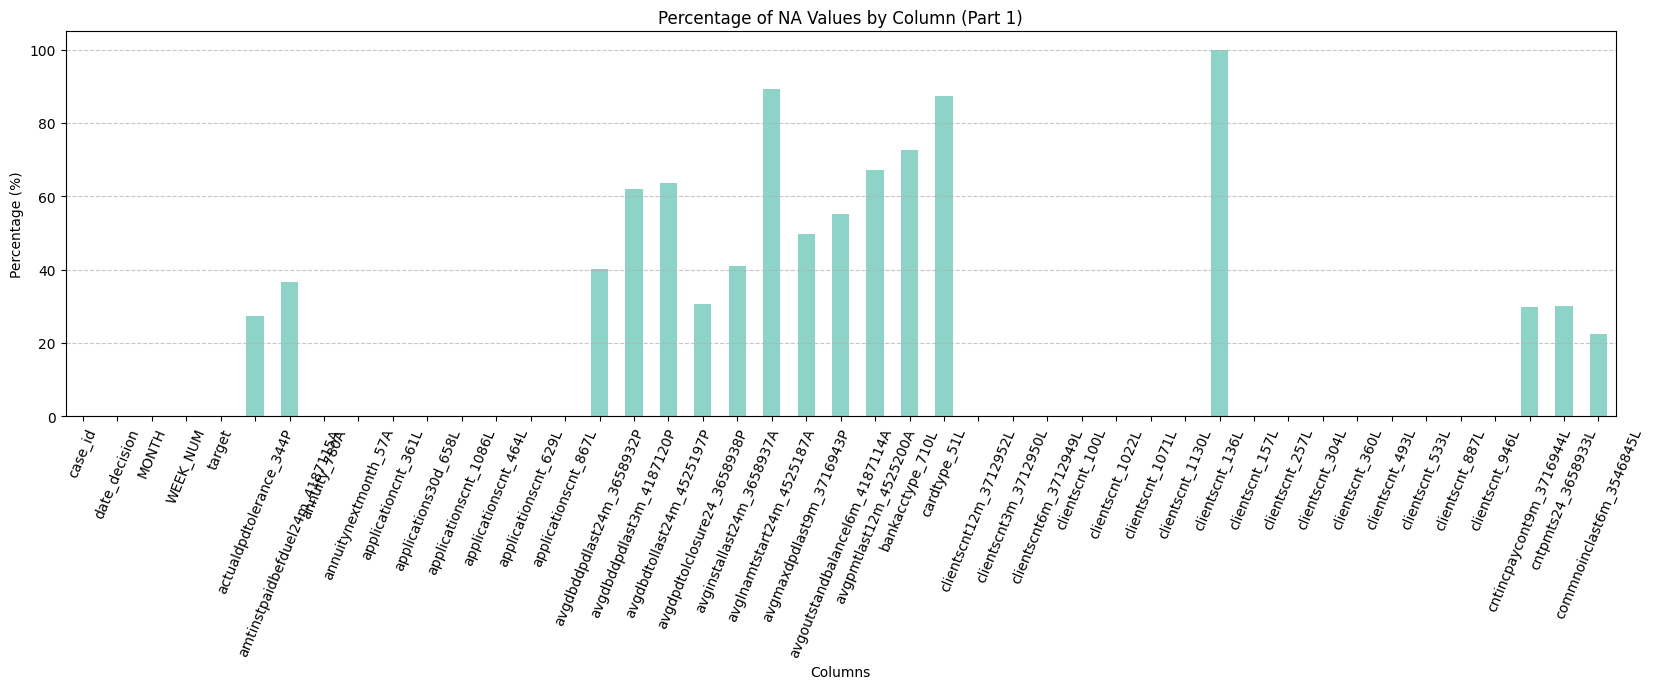

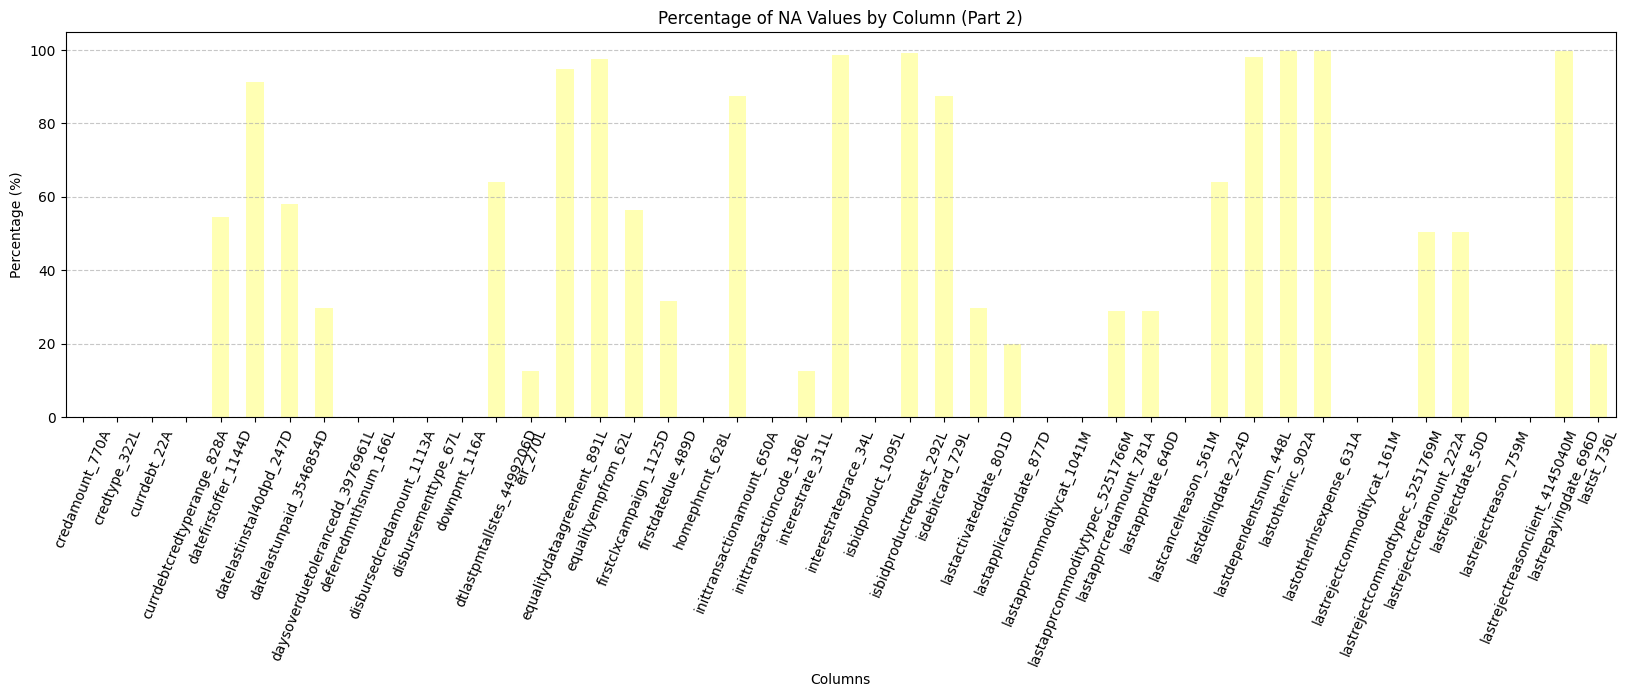

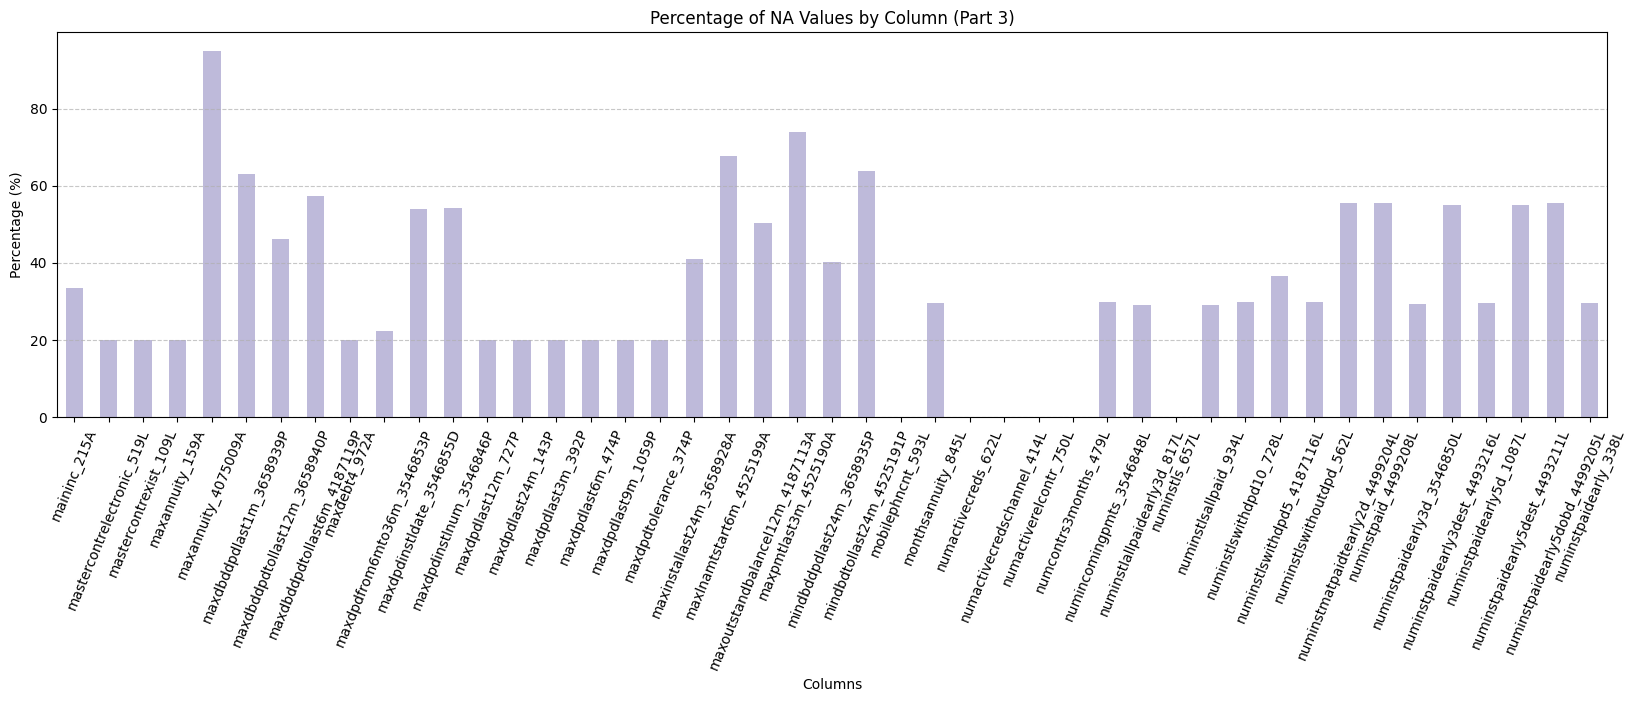

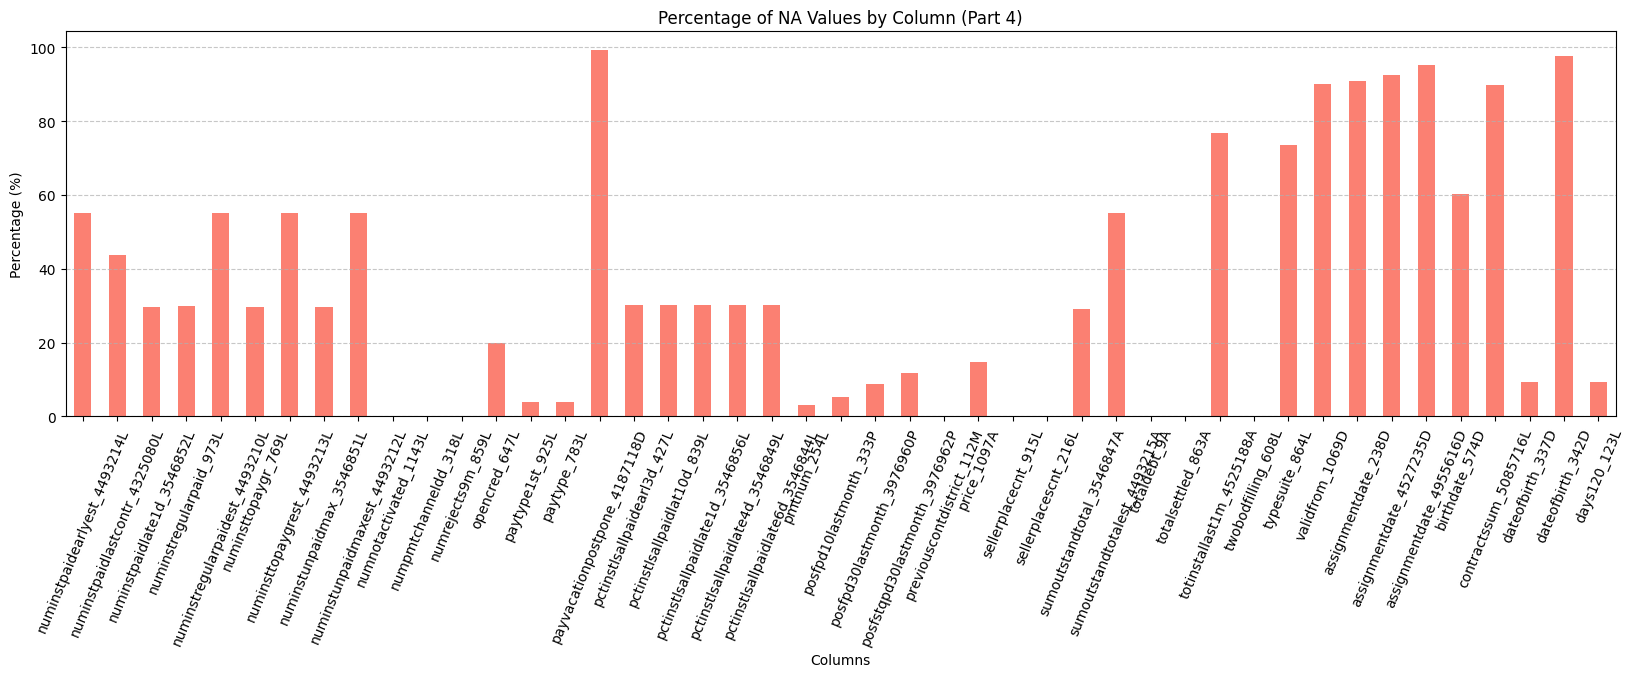

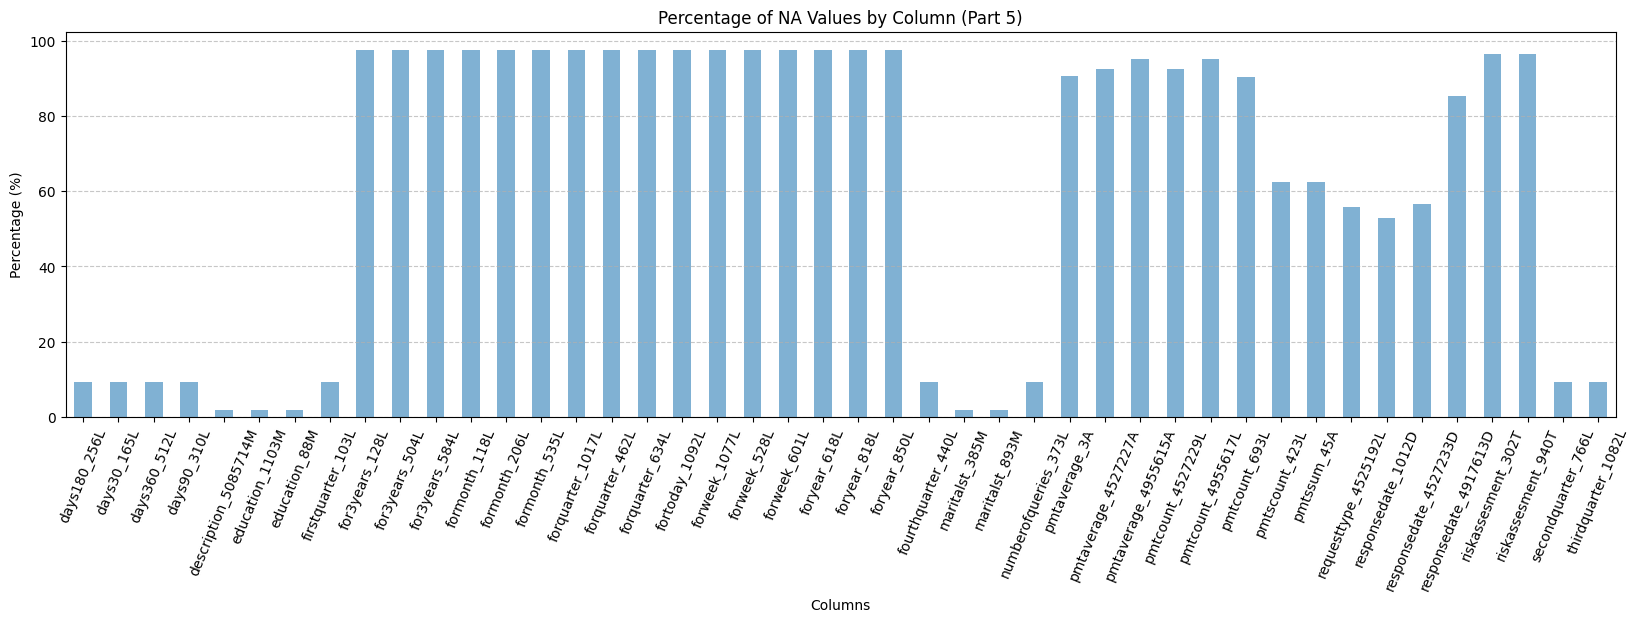

In [7]:
na_percentage = master_df.isna().sum() / len(master_df) * 100

# Calculate the number of columns per plot
num_columns = len(na_percentage)
columns_per_plot = num_columns // 5 + (num_columns % 5 > 0)

# Create plots
for i in range(5):
    plt.figure(figsize=(20, 5))
    start_index = i * columns_per_plot
    end_index = min(start_index + columns_per_plot, num_columns)
    na_percentage.iloc[start_index:end_index].plot(kind='bar', color=plt.cm.Set3(i))  # Using a color map for variety
    plt.title(f'Percentage of NA Values by Column (Part {i + 1})')
    plt.ylabel('Percentage (%)')
    plt.xlabel('Columns')
    plt.xticks(rotation=67.5)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

### Remove column NaN values

For now we will remove those columns in order to simplify model development. Maybe in a future iteration we can deep dive into those NaN values

In [8]:
columns_to_drop = na_percentage[na_percentage > 0].index
master_df = master_df.drop(columns=columns_to_drop)

In [9]:
master_df.head()

,case_id,date_decision,MONTH,WEEK_NUM,target,annuity_780A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,...,numactivecreds_622L,numactivecredschannel_414L,numactiverelcontr_750L,numcontrs3months_479L,numnotactivated_1143L,numpmtchanneldd_318L,numrejects9m_859L,previouscontdistrict_112M,sellerplacecnt_915L,sellerplacescnt_216L
0,0,2019-01-03,201901,0,0,1917.6,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,a55475b1,0.0,0.0
1,1,2019-01-03,201901,0,0,3134.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,a55475b1,0.0,0.0
2,2,2019-01-04,201901,0,0,4937.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,a55475b1,0.0,0.0
3,3,2019-01-03,201901,0,0,4643.6,0.0,1.0,0.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,a55475b1,1.0,1.0
4,4,2019-01-04,201901,0,1,3390.2,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,a55475b1,0.0,0.0


## EDA

In [10]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1526659 entries, 0 to 1526658
Data columns (total 51 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   case_id                          1526659 non-null  int64  
 1   date_decision                    1526659 non-null  object 
 2   MONTH                            1526659 non-null  int64  
 3   WEEK_NUM                         1526659 non-null  int64  
 4   target                           1526659 non-null  int64  
 5   annuity_780A                     1526659 non-null  float64
 6   applicationcnt_361L              1526659 non-null  float64
 7   applications30d_658L             1526659 non-null  float64
 8   applicationscnt_1086L            1526659 non-null  float64
 9   applicationscnt_464L             1526659 non-null  float64
 10  applicationscnt_629L             1526659 non-null  float64
 11  applicationscnt_867L             1526659 non-null 

In [11]:
master_df.shape

(1526659, 51)

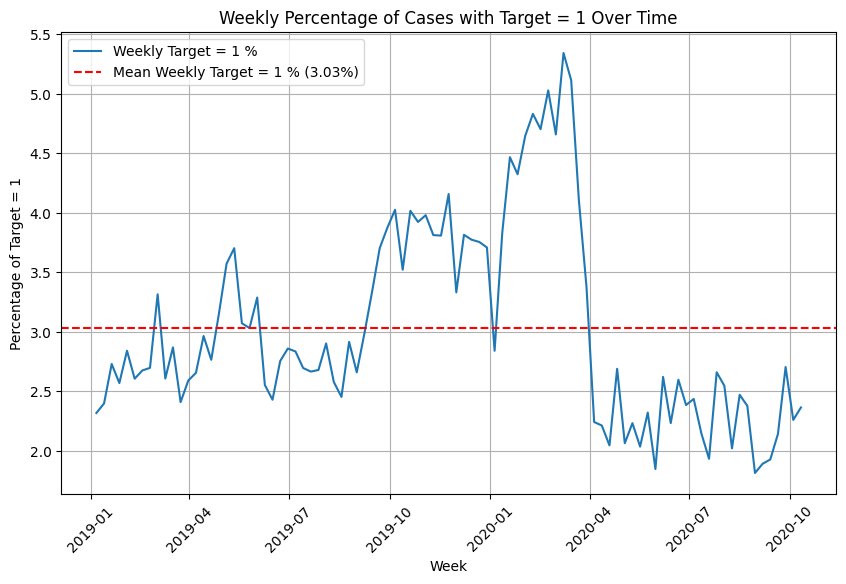

In [12]:
## How the target variable is distributed over time ? What the percentage of cases with target = 1 vs target = 2 overtime
grouped_data = master_df.groupby(['date_decision', 'target']).size().unstack(fill_value=0)
grouped_data
grouped_data['target_percentage'] = (grouped_data[1] / (grouped_data[0] + grouped_data[1])) * 100
mean_target_percentage = grouped_data['target_percentage'].mean()
grouped_data.index = pd.to_datetime(grouped_data.index)  # Make sure the index is datetime
weekly_data = grouped_data.resample('W').mean()
grouped_data.reset_index(inplace=True)
plot_data = grouped_data[["date_decision", "target_percentage"]]

plt.figure(figsize=(10, 6))
plt.plot(weekly_data.index, weekly_data['target_percentage'], label='Weekly Target = 1 %')
mean_target_percentage = weekly_data['target_percentage'].mean()
plt.axhline(y=mean_target_percentage, color='r', linestyle='--', label=f'Mean Weekly Target = 1 % ({mean_target_percentage:.2f}%)')
plt.xticks(rotation=45)
plt.xlabel('Week')
plt.ylabel('Percentage of Target = 1')
plt.title('Weekly Percentage of Cases with Target = 1 Over Time')
plt.legend()
plt.grid(True)
plt.show()

We can notice that the average % of case with target = 1 is around 3%

It means that the dataset is very imbalanced in terms of target class

In [13]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif

In [14]:
# Select K best features for continous variables using ANOVA test

X_cont = master_df.select_dtypes(include=[np.number])
y = master_df['target']

selector = SelectKBest(score_func=f_classif, k=10)
X_new_cont = selector.fit_transform(X_cont, y)

/home/ubuntu/Desktop/kaggle_project/home_credit/env/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 3 27] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/ubuntu/Desktop/kaggle_project/home_credit/env/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/home/ubuntu/Desktop/kaggle_project/home_credit/env/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [15]:
all_scores = selector.scores_  # This collects scores from the continuous selector
all_features = X_cont.columns  # Make sure to reference the correct original columns

# Create a Series to view features with their scores
cont_features_scores = pd.Series(all_scores, index=all_features).sort_values(ascending=False)
print(cont_features_scores[1:10])

numrejects9m_859L            6297.428953
mobilephncnt_593L            5293.654248
numcontrs3months_479L        4326.011225
sellerplacecnt_915L          3666.939817
applications30d_658L         2577.614474
disbursedcredamount_1113A    1187.328244
credamount_770A              1054.839413
numnotactivated_1143L         476.164836
annuity_780A                  292.398943
dtype: float64


In [16]:
## Keep only columns with top 10 F-score
##master_df = master_df[features_scores.index.to_list()[1:10] + ["target","date_decision"]]

In [17]:
# Select K best features for categorical variables using Chi-squared test
X_cat = master_df.drop(columns=["date_decision"])
X_cat = X_cat.select_dtypes(include=['object', 'category'])

mapping = {}
for col in X_cat.columns:
    unique_values = X_cat[col].unique()
    for val in unique_values:
        dummy_name = f"{col}_{val}"
        mapping[dummy_name] = col

X_cat = pd.get_dummies(X_cat, sparse=True)  # One-hot encoding

selector = SelectKBest(score_func=chi2, k=5)
X_new_cat = selector.fit_transform(X_cat, y)

In [18]:
all_scores = selector.scores_
all_features = X_cat.columns  # Make sure to reference the correct original columns

# # Create a Series to view features with their scores
cat_features_scores = pd.Series(all_scores, index=all_features).sort_values(ascending=False)
print(cat_features_scores[:10])

lastrejectreason_759M_P45_84_106               7505.244831
lastcancelreason_561M_P94_109_143              5426.286559
lastrejectreasonclient_4145040M_P94_109_143    4245.351521
lastrejectreason_759M_a55475b1                 2707.212772
lastrejectreasonclient_4145040M_a55475b1       2542.336534
lastcancelreason_561M_a55475b1                 1711.874441
lastrejectcommoditycat_161M_P159_130_59        1260.707511
lastrejectreason_759M_P99_56_166                880.752513
lastrejectreason_759M_P94_109_143               786.721946
lastcancelreason_561M_P64_121_167               342.827093
dtype: float64


In [19]:
cat_agg_scores = cat_features_scores.groupby(cat_features_scores.index.map(lambda x: mapping[x])).sum()
print(cat_agg_scores.sort_values(ascending=False))

lastrejectreason_759M              12062.877657
lastcancelreason_561M               8393.161991
lastrejectreasonclient_4145040M     7618.319950
previouscontdistrict_112M           1768.008783
lastrejectcommoditycat_161M         1688.650374
lastapprcommoditycat_1041M           769.559824
lastapprcommoditytypec_5251766M      212.740978
lastrejectcommodtypec_5251769M       200.738236
dtype: float64


## Feature selection

After performing our statistical tests, we will keep only top 10 continous features and top 5 categorical features for our model. In future iteration we could check if adding additional features would improve model

In [20]:
col_to_keep = cat_agg_scores.sort_values(ascending=False).index.to_list()[:5] + cont_features_scores.index.to_list()[1:10] \
                + ['case_id','target','date_decision','WEEK_NUM']

#col_to_keep = cont_features_scores.index.to_list()[1:10] + ['case_id','target','date_decision',"WEEK_NUM"]

In [21]:
cat_agg_scores.sort_values(ascending=False).index.to_list()[:5]

['lastrejectreason_759M',
 'lastcancelreason_561M',
 'lastrejectreasonclient_4145040M',
 'previouscontdistrict_112M',
 'lastrejectcommoditycat_161M']

In [23]:
features_df = master_df[col_to_keep]
features_df

features_df = pd.get_dummies(features_df, columns=cat_agg_scores.sort_values(ascending=False).index.to_list()[:5], drop_first=True)

## 1st modelling iteration

For our first iteration we will use a logistic regression as baseline

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_curve, auc, classification_report, roc_auc_score

In [25]:
X = features_df.drop(['target','date_decision','case_id',"WEEK_NUM"], axis=1)  # Features
y = features_df['target']  # Target variable

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
model = LogisticRegression(class_weight="balanced", max_iter=5000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

/home/ubuntu/Desktop/kaggle_project/home_credit/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Model Evaluation

The competition metric is a gini stability metric (detailled formula https://www.kaggle.com/competitions/home-credit-credit-risk-model-stability/overview).

We are evaluating our model against this metric.

In [28]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.70      0.82    295779
           1       0.05      0.53      0.10      9553

    accuracy                           0.70    305332
   macro avg       0.52      0.62      0.46    305332
weighted avg       0.95      0.70      0.80    305332

ROC AUC Score: 0.6548672018092991


In [29]:
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    gini_in_time = base.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1).tolist()
    
    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a*x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)
    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

In [30]:
base = features_df.copy()

In [31]:
score = model.predict(X)

In [32]:
len(score)

1526659

In [33]:
base['score'] = score

In [34]:
gini_stability(base)

0.2233886797396835

## Results

Our first model performance is a good start (a bit better than random) but clearly not yet satisfying. Comparing to the public leaderboard our solution is far from being a top perfoming one. For a usage in production, the peformance of the model is too low to make it deployable.

The class imbalance is likely to the main limiting factor of performance as the model is far better at predicting customer likely to repay their loan than the opposite.

Areas of improvment :
- More data (left out several files due to heavy preprocessing and computing resources required, might provide helpful features for modelling)
- Test other models/techniques more adapted for imbalanced class (sampling, other algorithms, etc)
- Tune logistic regession parameter to check if model performance is improved
- Handle differently the NaN values
- Test other methods for selecting features